# Exporing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import seaborn as sns
from scipy import stats


In [3]:
debt = pd.read_csv('debt.csv')
gdp = pd.read_csv('gdp.csv')

In [4]:
list_shortings = debt['Series Code'].unique()
shortings_DE = []
shortings_DL = []
shortings_DS = []

for i in range(len(list_shortings)):
    if list_shortings[i][7:9] == 'DE':
        shortings_DE.append(list_shortings[i])
    if list_shortings[i][7:9] == 'DL':
        shortings_DL.append(list_shortings[i])
    if list_shortings[i][7:9] == 'DS':
        shortings_DS.append(list_shortings[i])

shortings_DE

['DP.DOD.DECD.CR.PS.CD',
 'DP.DOD.DECN.CR.PS.CD',
 'DP.DOD.DECX.CR.PS.CD',
 'DP.DOD.DECF.CR.PS.CD',
 'DP.DOD.DECT.CR.PS.CD']

In [5]:
debt[debt['Series Code'] == 'DP.DOD.DSOA.CR.PS.CD']['Series Name'].unique()

array(['Gross PSD - Total - Short-term - Other accounts payable - Nominal Value - US$'],
      dtype=object)

**ABBRIVIATIONS 'Series Code'**
---
DP.DOD.DE--.CR.PS.CD: 
- Gross PSD - Total - All maturities - All instruments - XXXXXXXXXX - Nominal Value - US$

DECD = Domestic creditors

DECN = Domestic currency

DECX = External creditors

DECF = Foreign currency

DECT =  'No specification'

---

DP.DOD.DL--.CR.PS.CD:
- Gross PSD - Total - All maturities - XXXXXXX - Nominal Value - US$

DP.DOD.DL--.CR.MV.PS.CD:
- Gross PSD - Total - All maturities - XXXXXXX - Market value - US$ - (Only DLDS)

DP.DOD.DL--.CR.M1.PS.CD:
- Gross PSD - Total - Long-term - With payment due in more than one year - XXXXXXX - Nominal Value - US$

DP.DOD.DL--.CR.L1.PS.CD:
- Gross PSD - Total - Long-term - With payment due in one year or less - XXXXXXX - Nominal Value - US$


**PS,M1:**

DLSD = Special Drawing Rights


**PS,M1,L1:**

DLCD = Currency and deposits

DLIN = Insurance - pensions - and standardized guarantee schemes

DLLO = Loans 

DLOA = Other accounts payable

DLTC = All instruments


**PS,M1,L1,MV:**

DLDS = Debt securities

----
DP.DOD.DS--.CR.PS.CD
- Gross PSD - Total - Short-term - XXXXXXX - Nominal Value - US$

DSTC = All instruments

DSCD = Currency and deposits

DSDS = Debt securities

DSIN = Insurance - pensions - and standardized guarantee schemes

DSLO = Loans 

DSOA = Other accounts payable


# 1

Preprocess the public debt file to obtain a data frame with country, type of debt, date and amount of debt.

In [6]:
debt.head(1)

,Country Name,Country Code,Series Name,Series Code,1995Q1 [YR1995Q1],1995Q2 [YR1995Q2],1995Q3 [YR1995Q3],1995Q4 [YR1995Q4],1996Q1 [YR1996Q1],1996Q2 [YR1996Q2],...,2017Q3 [YR2017Q3],2017Q4 [YR2017Q4],2018Q1 [YR2018Q1],2018Q2 [YR2018Q2],2018Q3 [YR2018Q3],2018Q4 [YR2018Q4],2019Q1 [YR2019Q1],2019Q2 [YR2019Q2],2019Q3 [YR2019Q3],2019Q4 [YR2019Q4]
0,Albania,ALB,Gross PSD - Total - All maturities - All instr...,DP.DOD.DECD.CR.PS.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8.157783e+09,8.582931e+09,8.899611e+09,8.702529e+09,9.089519e+09,9.260168e+12,9.766709e+09,9.107545e+09,8.941897e+09,NaN


In [7]:
debt_long = debt.melt(id_vars=['Country Name', 'Country Code', 'Series Name', 'Series Code'], var_name='Date', value_name='Debt')

In [8]:
debt_long_cleaning = debt_long.copy()

In [9]:
debt_long_cleaning = debt_long_cleaning.dropna(subset = 'Debt')

In [10]:
# Split column Date at space and keep only first part
debt_long_cleaning.loc[:, 'Date'] = debt_long_cleaning['Date'].str.split(' ').str[0]


In [11]:
debt_long_cleaning.reset_index(drop=True, inplace=True)

In [12]:
# TODO Cleaning needed?
debt_long = debt_long_cleaning.copy()  

# 2

Create a function that receives a country and a date and returns a dictionary with the total internal, external, local currency, foreign currency, short term and long term debt of that country on that date.

In [13]:
def extract_data(country, date):
    df = debt_long[(debt_long['Country Name'] == country) & (debt_long['Date'] == date)]
    dictionary = {
        'Total  Internal': df[df['Series Code'] == 'DP.DOD.DECD.CR.PS.CD']['Debt'].iloc[0],
        'Total External': df[df['Series Code'] == 'DP.DOD.DECX.CR.PS.CD']['Debt'].iloc[0],
        'Local Currency': df[df['Series Code'] == 'DP.DOD.DECN.CR.PS.CD']['Debt'].iloc[0],
        'Foreign Currency': df[df['Series Code'] == 'DP.DOD.DECF.CR.PS.CD']['Debt'].iloc[0],
        'Short Term Debt': df[df['Series Code'] == 'DP.DOD.DSTC.CR.PS.CD']['Debt'].iloc[0],
        'Long Term Debt': df[df['Series Code'] == 'DP.DOD.DLTC.CR.PS.CD']['Debt'].iloc[0]
    }
    return dictionary

extract_data('Canada', '2019Q3')




IndexError: single positional indexer is out-of-bounds

# 3

Create a function that receives a type of debt and a date, and returns a dictionary with the debt of that type for all countries on that date.

In [14]:
def get_countries(debt_type, date):
    df = debt_long[(debt_long['Series Code'] == debt_type) & (debt_long['Date'] == date)]
    df.dropna(subset='Debt')
    dict_countries = {}
    for index, row in df.iterrows():
        dict_countries[row['Country Name']] = row['Debt']
    return dict_countries

get_countries('DP.DOD.DECD.CR.PS.CD', '2019Q3')


{'Albania': 8941896949.59713,
 'Australia': 1114269348600.0,
 'Bangladesh': 96231778868146.0,
 'Canada': 1684184097258.93,
 "Cote d'Ivoire": 7303277668.2345,
 'El Salvador': 9698293221.40753,
 'Fiji': 1969206748.98782,
 'Georgia': 5046625541.98038,
 'Guatemala': 11289337800.3472,
 'Honduras': 5378995439.44341,
 'Indonesia': 448875576734594.0,
 'Mauritius': 7496502351999.0,
 'Mexico': 299616679524033.0,
 'Moldova': 1382453965.16724,
 'Paraguay': 1051684486.6738,
 'Seychelles': 498345922.827003,
 'Slovak Republic': 24694318041.1664,
 'St. Lucia': 630378404.74814,
 'Uganda': 7457687392.65621}

# 4

Create a function that receives a country and a date and draws a pie chart with the internal debt and external debt of that country on that date.

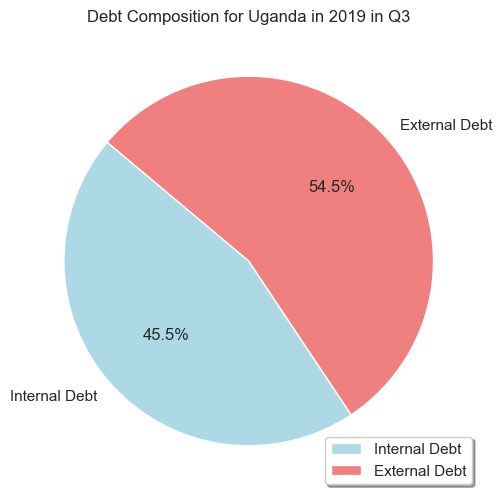

In [15]:
def pie_cart(country, date):
    df = debt_long[(debt_long['Country Name'] == country) & (debt_long['Date'] == date)]
    internal_debt  = df[df['Series Code'] == 'DP.DOD.DECD.CR.PS.CD']['Debt'].iloc[0]
    external_debt =  df[df['Series Code'] == 'DP.DOD.DECX.CR.PS.CD']['Debt'].iloc[0]

    labels = ['Internal Debt', 'External Debt']
    sizes = [internal_debt, external_debt]

    plt.figure(figsize=(6, 6))
    sns.set(style="whitegrid")
    sns.color_palette("pastel")
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightcoral'])
    plt.title(f'Debt Composition for {country} in {date[:4]} in {date[-2:]}')
    # Show the legend at the bottom with the amount of debt
    plt.legend(loc='lower right', shadow=True, ncol=1)
    plt.show()


pie_cart('Uganda', '2019Q3')


# 5

Create a function that receives a country and a date, and draws a bar chart with the amounts of the different types of debts of that country on that date

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def pie_chart(country, date):
    df = debt_long[(debt_long['Country Name'] == country) & (debt_long['Date'] == date)]

   # TODO Create Function, what should we display?

pie_chart('Uganda', '2019Q3')


# 6

Create a function that receives a list of countries and a type of debt and draws a line chart showing the evolution of that type of debt for those countries (one line per country)

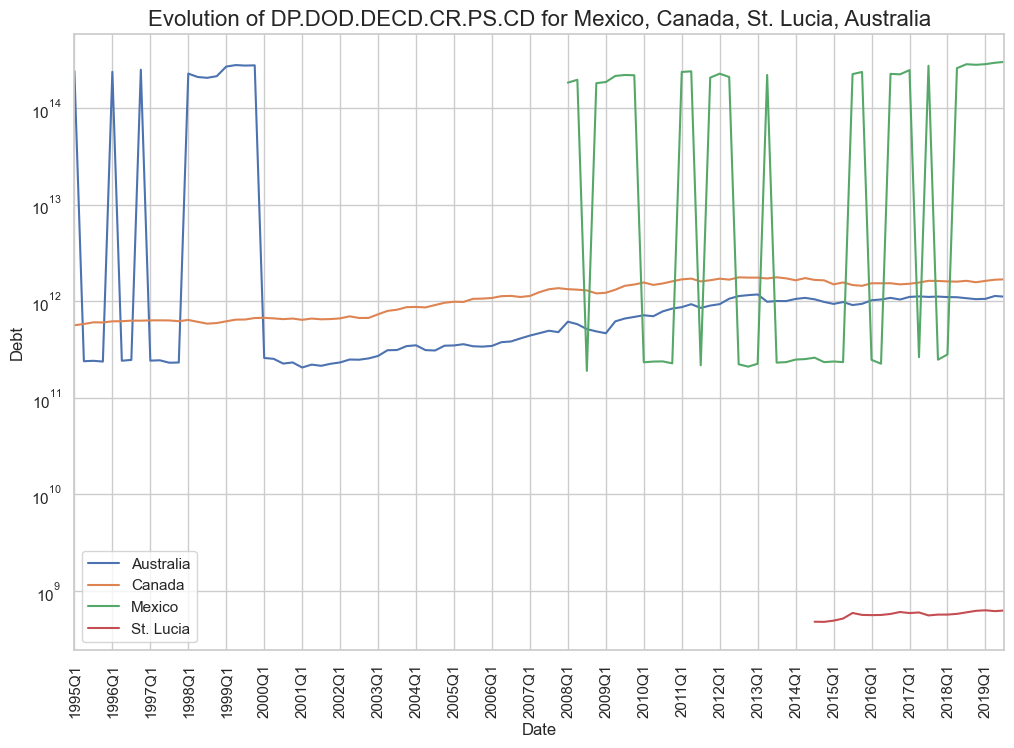

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exercise 6
def line_chart_countries(countries, debt_type):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.title(f'Evolution of {debt_type} for {", ".join(countries)}', fontsize=16)
    sns.set(style="whitegrid")
    country_data = debt_long[(debt_long['Country Name'].isin(countries)) & debt_long['Series Code'].str.contains(debt_type)]
    sns.lineplot(x='Date', y='Debt',hue = 'Country Name', data=country_data, palette='muted')
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Debt')
    plt.yscale('log')
    plt.xlim(country_data['Date'].iloc[0], country_data['Date'].iloc[-1])
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(4))
    plt.legend()
    plt.show()

# Example usage:
countries_to_plot = ['Mexico', 'Canada', 'St. Lucia', 'Australia']
debt_type_to_plot = 'DP.DOD.DECD.CR.PS.CD'  
line_chart_countries(countries_to_plot, debt_type_to_plot)

# TODO look at 'Australia' or 'Mexico' do we need to clean the data or those just strange spikes?


# 7

Create a function that receives a country and a list of debt types and draws a line chart showing the evolution of those debt types for that country (one line per debt type).

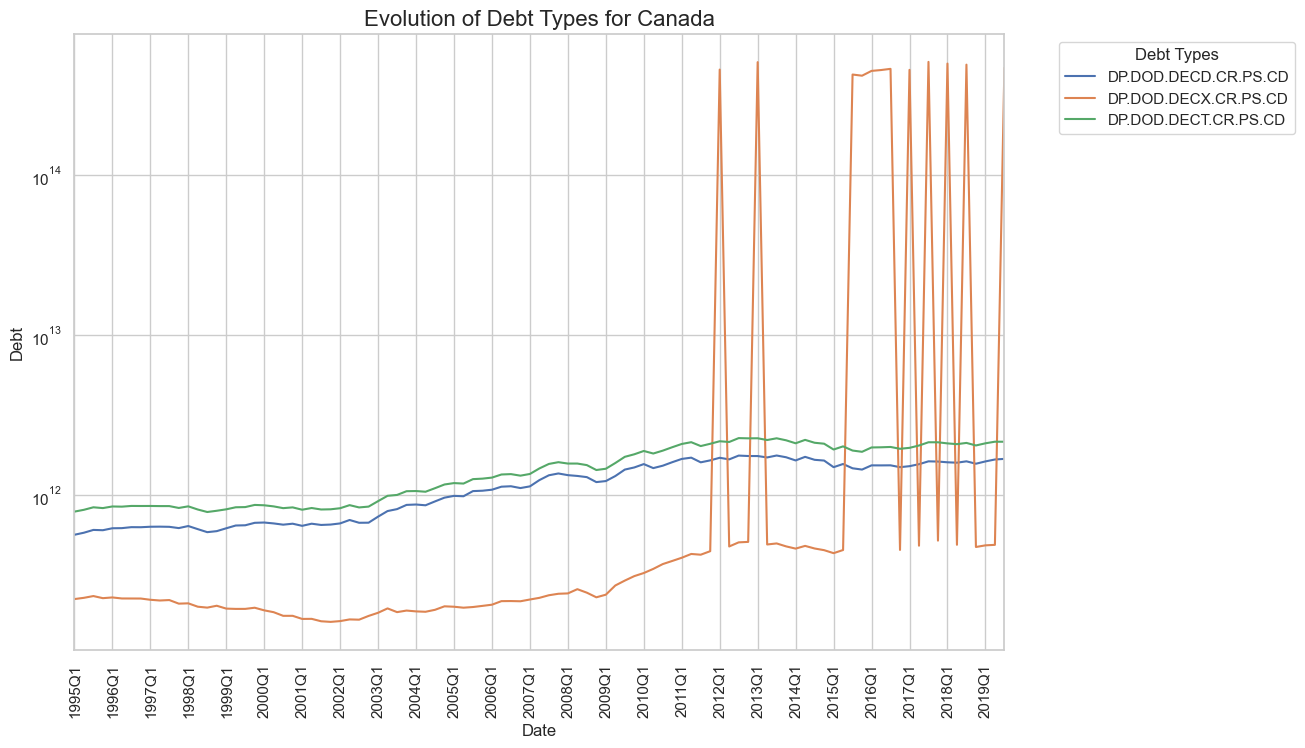

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def line_chart_debt_types(country, debt_types):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.set(style="whitegrid")
    plt.title(f'Evolution of Debt Types for {country}', fontsize=16)
    country_data = debt_long[(debt_long['Country Name'] == country) & debt_long['Series Code'].isin(debt_types)]
    sns.lineplot(x='Date', y='Debt', hue='Series Code', data=country_data, palette='muted')
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Debt')
    plt.yscale('log')
    plt.xlim(country_data['Date'].iloc[0], country_data['Date'].iloc[-1])
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(4))
    plt.legend(title='Debt Types', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()



# Example usage:
country_to_plot = 'Canada'
debt_types_to_plot = ['DP.DOD.DECD.CR.PS.CD', 'DP.DOD.DECX.CR.PS.CD', 'DP.DOD.DECT.CR.PS.CD']
line_chart_debt_types(country_to_plot, debt_types_to_plot)


# 8

Create a function that receives a list of countries and a list of types of debt, and draw a box plot of debt

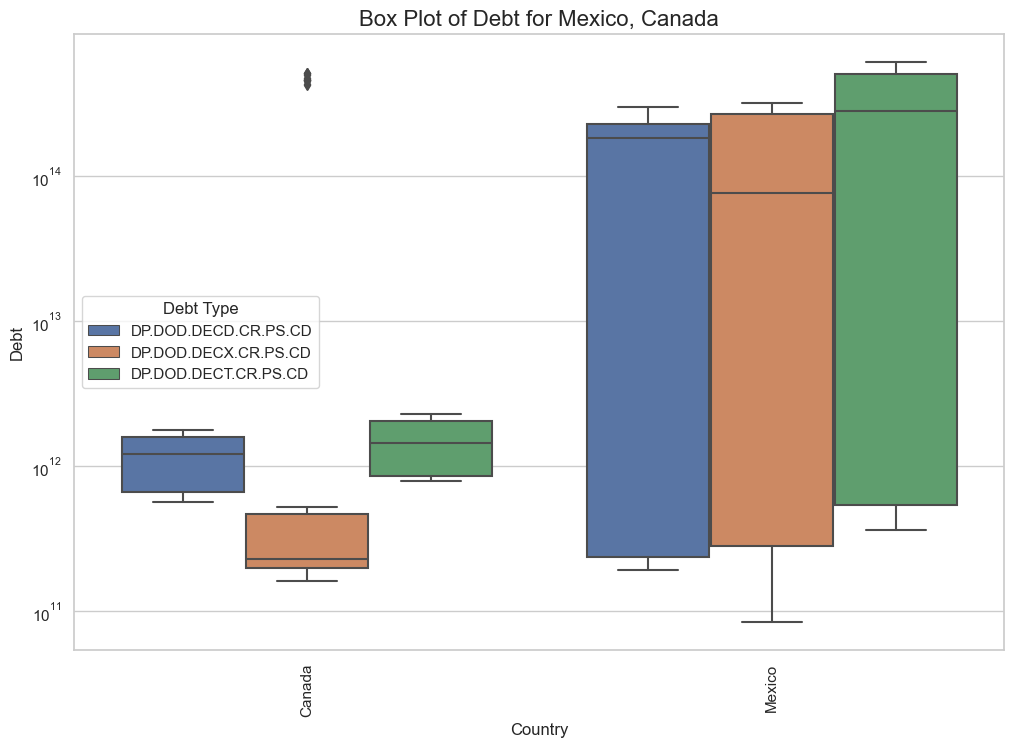

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def box_plot_countries(countries, debt_types):
    # Filter data for the selected countries and debt types
    filtered_data = debt_long[(debt_long['Country Name'].isin(countries)) & (debt_long['Series Code'].isin(debt_types))]
    # Create a box plot
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.set(style="whitegrid")
    palette = sns.color_palette("muted")
    plt.title(f'Box Plot of Debt for {", ".join(countries)}', fontsize=16)
    sns.boxplot(x='Country Name', y='Debt', hue='Series Code', data=filtered_data, palette=palette)
    plt.xticks(rotation=90)
    plt.xlabel('Country')
    plt.ylabel('Debt')
    plt.yscale('log')
    plt.legend(title='Debt Type')
    plt.show()

# Example usage:
countries_to_plot = ['Mexico', 'Canada']
debt_types_to_plot = ['DP.DOD.DECD.CR.PS.CD', 'DP.DOD.DECX.CR.PS.CD', 'DP.DOD.DECT.CR.PS.CD']
box_plot_countries(countries_to_plot, debt_types_to_plot)
